We study the DEBY 2021.01 forward contract for German baseload power using the Variance Gamma (VG) process as the underlying model for log-price dynamics.  

The dataset `Historical_Prices_FWD_Germany.csv` contains daily settlement prices, from which we construct log-returns for historical calibration up to 2019-11-19.  
For the risk-neutral calibration, we use exchange-quoted European call option prices on the same forward, taken from `Options_Prices_Calendar_2021.csv`, and covering several maturities and strikes.

In accordance with [Gardini's presentation](vg_energy_markets_helsinki.pdf) I assume that the log-returns of the German power calendar 2021 (the contract that delivers electricity every hour in 2021) are driven by a Variance Gamma process as described in slide 19, the log-prices of a given risky asset $S$ follow the dynamic:
$$d \log S(t) = \theta \, dg(t) + \sigma \, dW\left(g(t)\right),$$
where
- $S(0) = S_0$ ,

- $t \geq 0$ ,

- $\theta \in \mathbb{R}$ ,

- $\sigma \in \mathbb{R}^+$ ,

- $g = \{ g(t); t \geq 0 \}$ is a Gamma process

- $\displaystyle g(t) \sim \Gamma\left( \frac{t}{\nu}, \nu \right)$ ,

- $\nu \in \mathbb{R}^+$ and $W$ is a standard Brownian motion independent of $g$ .

In this case the vector parameter we want to estimate is $\Theta = (\theta, \sigma, \nu)$ .

## Historical calibration

I loaded the data from `Historical Prices FWD Germany.csv`. The functions i used for this are in `dataloader.py`.

Libraries

- `numpy` and

- `pandas` will be needed as well, alongside with

- module `stats` from `scipy`,

- `mimnimize` from `scipy.optimize`,

- `matplotlib.pyplot` and

- `statmodels.api` (as `sm`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import minimize
from dataloader import cutoff_date, load_hfwd, load_options_snapshot, load_forward_price

In [2]:
cutoff_date = pd.Timestamp("2019-11-19")

prices = load_hfwd()
print(prices.head())

prices = prices.loc[prices.index <= cutoff_date].sort_index()
assert len(prices) > 3, "No data found up to 2019-11-19."

logp = np.log(prices.values)
data = np.diff(logp)
data = data[data != 0.0]

dt = 1/252  # trading-day fraction used in Gardini's MATLAB script

date
2017-04-25    28.98
2017-04-26    28.80
2017-04-27    28.96
2017-04-28    29.04
2017-05-02    28.89
Name: DEBY2021, dtype: float64


### Summary statistics and ACF
I calculated the following summary statistics from the time series:

                                     Value
N                                      639
Mean                              0.000743
Std. dev.                         0.012217
Annualized vol                    0.193941
Median                             0.00102
Min                               -0.07733
Max                               0.055345
Skewness                         -0.227109
Kurtosis (non-excess)             6.467958
Kurtosis (excess)                 3.467958
Count(|ret| > 2σ)                       27
Count(|ret| > 3σ)                        5
Date of max |ret|      2018-09-13 00:00:00
Max |ret| value                   -0.07733


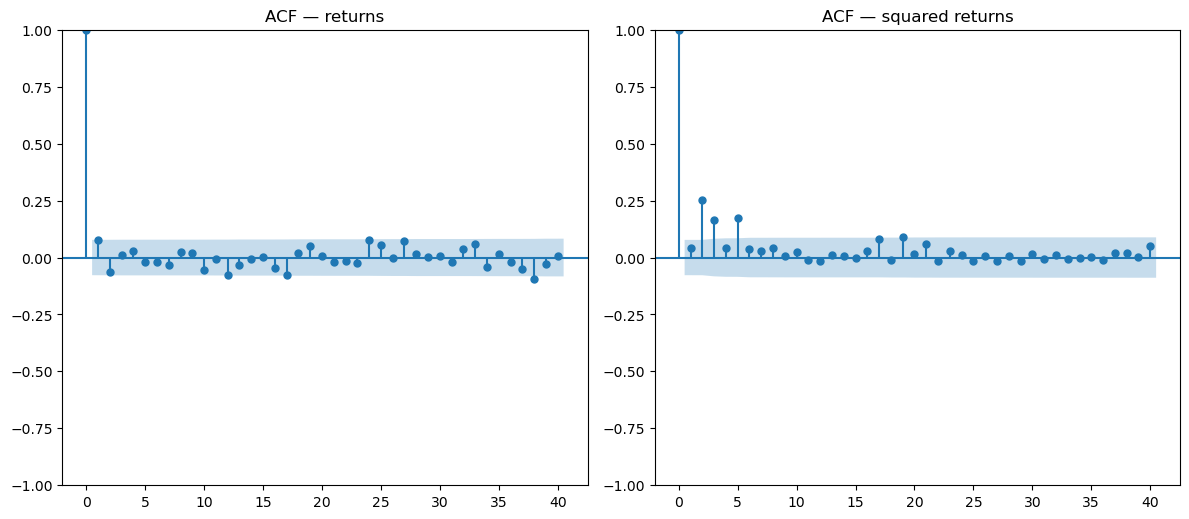

In [3]:
all_rets = np.diff(np.log(prices.values))
ret_dates_all = prices.index[1:]
mask_nonzero = (all_rets != 0.0)
ret_dates = ret_dates_all[mask_nonzero]

n = len(data)
mean = data.mean()
std  = data.std(ddof=1)
med  = np.median(data)
mn, mx = data.min(), data.max()
skew = stats.skew(data, bias=False)
kurt_nonexcess = stats.kurtosis(data, fisher=False, bias=False)
kurt_excess    = stats.kurtosis(data, fisher=True,  bias=False)

ann_vol = np.sqrt(np.var(data, ddof=1) * 252)

thr2 = 2*std
thr3 = 3*std
n_gt_2s = int(np.sum(np.abs(data) > thr2))
n_gt_3s = int(np.sum(np.abs(data) > thr3))

imax = int(np.argmax(np.abs(data)))
date_max_abs = ret_dates[imax] if n == len(ret_dates) else ret_dates[min(imax, len(ret_dates)-1)]
max_abs_val  = data[imax]

summary = pd.DataFrame({
    "Value": [
        n, mean, std, ann_vol, med, mn, mx, skew, kurt_nonexcess, kurt_excess,
        n_gt_2s, n_gt_3s, pd.Timestamp(date_max_abs), max_abs_val
    ]
}, index=[
    "N",
    "Mean",
    "Std. dev.",
    "Annualized vol",
    "Median",
    "Min",
    "Max",
    "Skewness",
    "Kurtosis (non-excess)",
    "Kurtosis (excess)",
    "Count(|ret| > 2σ)",
    "Count(|ret| > 3σ)",
    "Date of max |ret|",
    "Max |ret| value"
])

print(summary)

fig = plt.figure(figsize=(12, 10))

ax1 = plt.subplot(2,2,1)
sm.graphics.tsa.plot_acf(data, lags=40, ax=ax1)
ax1.set_title("ACF — returns")

ax2 = plt.subplot(2,2,2)
sm.graphics.tsa.plot_acf(data**2, lags=40, ax=ax2)
ax2.set_title("ACF — squared returns")

plt.tight_layout()
plt.show()

The high excess kurtosis of $\gamma_2\approx 3.47$ confirms heavy tails compared to the normal distribution, justifying the use of a Variance Gamma model over a Gaussian assumption.

The return series shows near-zero autocorrelation in raw returns, but significant short-lag autocorrelation in squared returns, indicating volatility clustering. *This could be a good starting point for improving the model, but I will not use it in solving this exam problem.*

I fitted the VG parameters to historical log-returns by maximum likelihood estimation (MLE), using the exact transition densitygiven in Equation $(1)$, slide 20 of Gardini's presenation:
$$f_{\Theta}(x_i) = \frac{\displaystyle 2\,\exp\left(\frac{\theta \cdot x}{\sigma^2}\right)}{\displaystyle\sigma\,\sqrt{2\,\pi}\,\nu^{\displaystyle\tfrac{\Delta t}{\nu}}\,\Gamma\left(\frac{1}{\nu}\right)}
\left( \frac{|x|}{\displaystyle\sqrt{\frac{2 \sigma^2}{\nu} + \theta^2}} \right)^{\displaystyle\tfrac{\Delta t}{\nu} - \tfrac12}
K_{\displaystyle\tfrac{\Delta t}{\nu} - \tfrac12} \left( \frac{\displaystyle|x| \sqrt{\frac{2 \, \sigma^2}{\nu} + \theta^2}}{\sigma^2} \right)\tag{1}$$where

- $\Gamma(x)$ is the Gamma function and

- $K_\eta(\cdot)$ is the modified Bessel function of the Third kind.

I will minimize the log likelihood o the model. Woking with the log-likelihood function is beneficial for, among other things, numerical stability, the likelihood function is generally a product of very small numbers.

The functions `VGdensity`, `neg_loglike`, `VG_simulation` (further described in the appendix), are implemented in `vg_model.py`.

In [4]:
from vg_model import VGdensity, neg_loglike, VG_simulation

To get a starting point for the calibration, I used the Generalized Method of Moments, as suggested by Gardini.

In [5]:
M = data.mean()
V = data.var(ddof=0)
S = stats.skew(data, bias=False)
K = stats.kurtosis(data, fisher=False, bias=False)

sigma0 = np.sqrt(V/dt)
nu0    = (K/3 - 1) * dt
theta0 = (S * sigma0 * np.sqrt(dt)) / (3 * nu0) if nu0>0 else 0.0

theta0, nu0, sigma0

(-0.20146107903469826, 0.004587246597221976, 0.19378940358599753)

With these values, the calibration can be performed.

Instead of the SQP (Sequential Quadratic Programming) that I belive was used as a default by `fmincon` to minimize the negative log likelihood in the MATLAB script, I used L-BFGS-B optimizer.

In [6]:
x0 = np.array([theta0, nu0, sigma0], dtype=float)
bounds = [(-1e6, 1e6), (1e-12, 1e6), (1e-12, 1e6)]

res = minimize(neg_loglike, x0, args=(data, dt),
               method="L-BFGS-B", bounds=bounds,
               options=dict(maxiter=50000, maxfun=50000))

theta_hat, nu_hat, sigma_hat = res.x
print("Success:", res.success, "| nll:", res.fun)
theta_hat, nu_hat, sigma_hat

Success: True | nll: -1930.367717351444


/home/ambrus/Dokumentumok/UH/SMEM/exam_project_gardini/vg_model.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  v1  = 2.0*np.exp((theta*x)/(sigma**2)) / ((nu**a)*np.sqrt(2*np.pi)*sigma*gamma(a))


(0.1873151458924215, 0.0019834955999441578, 0.1916806510946026)

### Fitted distribution compared to the historical one
To check my results, I created a plot similar to the one on slide 39 of the presentation.

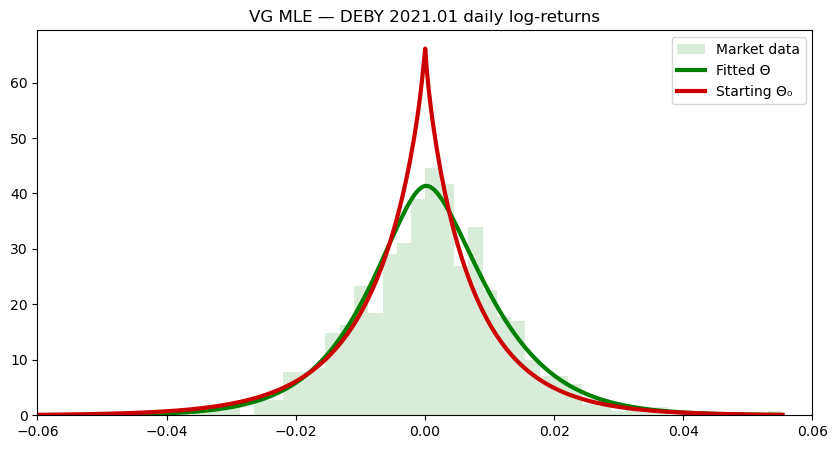

In [7]:
x_grid = np.linspace(data.min(), data.max(), 500)
fx_st  = VGdensity(x_grid, theta0, nu0, sigma0, dt)

fx = VGdensity(x_grid, theta_hat, nu_hat, sigma_hat, dt)

fig = plt.figure(figsize=(10,5))
h = plt.hist(data, bins=60, density=True, alpha=0.15, color=(0,0.5,0), label="Market data")
plt.plot(x_grid, fx,  "-", lw=3, color=(0,0.5,0), label="Fitted Θ")
plt.plot(x_grid, fx_st,"-", lw=3, color=(0.8,0,0), label="Starting Θ₀")
plt.legend()
plt.xlim(-0.06, 0.06)
plt.title("VG MLE — DEBY 2021.01 daily log-returns")
plt.show()

### Q-Q plot: Market vs VG-simulated log-returns

Also I displayed the market vs VG-simulated log-returns on a Q-Q plot.

The function `VGSimulation.m` is implemented in `vg_model.py`:

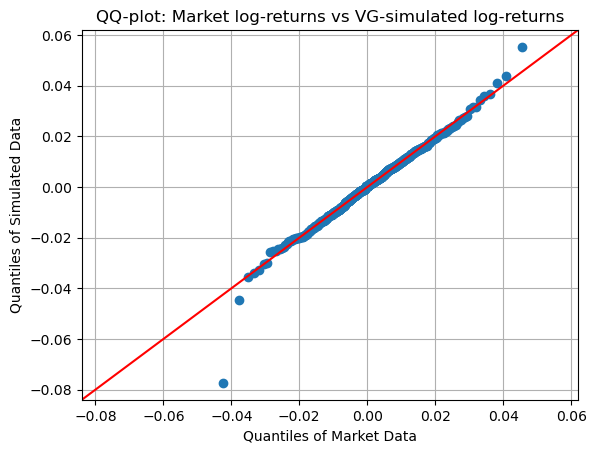

In [8]:
nSim   = 500
nDates = len(prices)
X_sim  = VG_simulation(nSim, nDates, dt, (theta_hat, nu_hat, sigma_hat))

Y_sim = np.diff(X_sim, axis=1).ravel()

fig = sm.qqplot_2samples(data, Y_sim, line='45')
plt.title("QQ-plot: Market log-returns vs VG-simulated log-returns")
plt.xlabel("Quantiles of Market Data")
plt.ylabel("Quantiles of Simulated Data")
plt.grid(True)
plt.show()

### Discussion of the results of MLE calibration
The estimated parameters are extremely close to those reported by Gardini:  
$$
\text{Gardini's results: } (\theta,\sigma,\nu)=(0.1873,\,0.1917,\,0.0020),
$$
$$
\text{My results: } (\theta,\sigma,\nu)=(0.187315,\,0.191681,\,0.0019835).
$$
This near match (further confirmed by the visualizations) indicates both the correctness of the implementation and the stability of MLE for the VG process on this dataset.  

## Risk-neutral calibration

In the risk-neutral setting, we replace historical parameters with those that fit market option prices.  
Because we are dealing with forwards (not spot prices), the correct framework is Black-76, where  
$$
C(K,T) = e^{-rT}\,\mathbb{E}^{\mathbb{Q}}\!\big[(F_T-K)^+\big]
$$
and the forward log-price evolves under $\mathbb{Q}$ as:

- $\displaystyle\log F_T = \log F_0 + \omega T + X_T$,

- $\displaystyle\omega = \frac{1}{\nu}\log\!\left(1 - \theta\nu - \frac12\sigma^2\nu\right)$.

We use the Carr–Madan FFT[^1] method to efficiently compute call prices for many strikes from the VG characteristic function:
$$
\phi_{VG}(u) = \exp\left(iu(\log F_0 + \omega T)\right)
\left( 1 - i\theta\nu u + \frac12\sigma^2\nu u^2 \right)^{\displaystyle\tfrac{-T}{\nu}}.
$$
The FFT provides prices on a log-strike grid, which we interpolate to the market strikes.  
Calibration minimizes the sum of squared price errors across all available maturities and strikes.

[^1]: Carr, P. & Madan, D. B. (1999). “Option valuation using the Fast Fourier Transform.” *Journal of Computational Finance*, 2(4), 61–73. [PDF](https://engineering.nyu.edu/sites/default/files/2018-08/CarrMadan2_0.pdf)



- `omega_vg`, `phi_vg_b76`, `FFTPricing`, `price_slice_fft_b76` and `resid_vector_squared` are implemented in `vg_model.py` and described in the [appendix](#Appendix).

- Additional packages to import:
- `least_squares` from `scipy.optimize`

In [9]:
from scipy.optimize import least_squares
from vg_model import omega_vg, phi_vg_b76, FFTPricing
from vg_model import price_slice_fft_b76, resid_vector_squared

Loading the data. The functions i used for this are in `dataloader.py` as well.

In [10]:
snap = load_options_snapshot()
F0 = load_forward_price()

print(snap.head())
print("F0 =", F0)

      K         T       P
0  24.5  0.350685  22.100
1  25.0  0.350685  21.600
2  25.5  0.350685  21.100
3  26.0  0.350685  20.601
4  26.5  0.350685  20.101
F0 = 46.6


I define the risk-free rate as $r=0.01$. Although it is not used in the Black76 model, it is still needen for discounting at the end.

In [11]:
r = 0.01

In [12]:
from scipy.optimize import least_squares
from vg_model import resid_vector_squared, price_slice_fft_b76

T_arr = snap["T"].to_numpy(float)
K_arr = snap["K"].to_numpy(float)
P_arr = snap["P"].to_numpy(float)

x0 = np.array([1.05, 0.02, 0.2])
lb = np.array([-2.7, 0.01, 0.02])
ub = np.array([ 2.7, 0.80, 1.10])

res = least_squares(
    resid_vector_squared,
    x0,
    bounds=(lb, ub),
    args=(F0, T_arr, r, K_arr, P_arr),
    max_nfev=5000, xtol=1e-12, ftol=1e-12, gtol=1e-12
)

theta_rn, nu_rn, sigma_rn = res.x
print("RN params (Black-76):", theta_rn, nu_rn, sigma_rn)

RN params (Black-76): -0.043617941185485176 0.5151900919326116 0.25434145259226315


### Plot: Market Repricing for different maturities

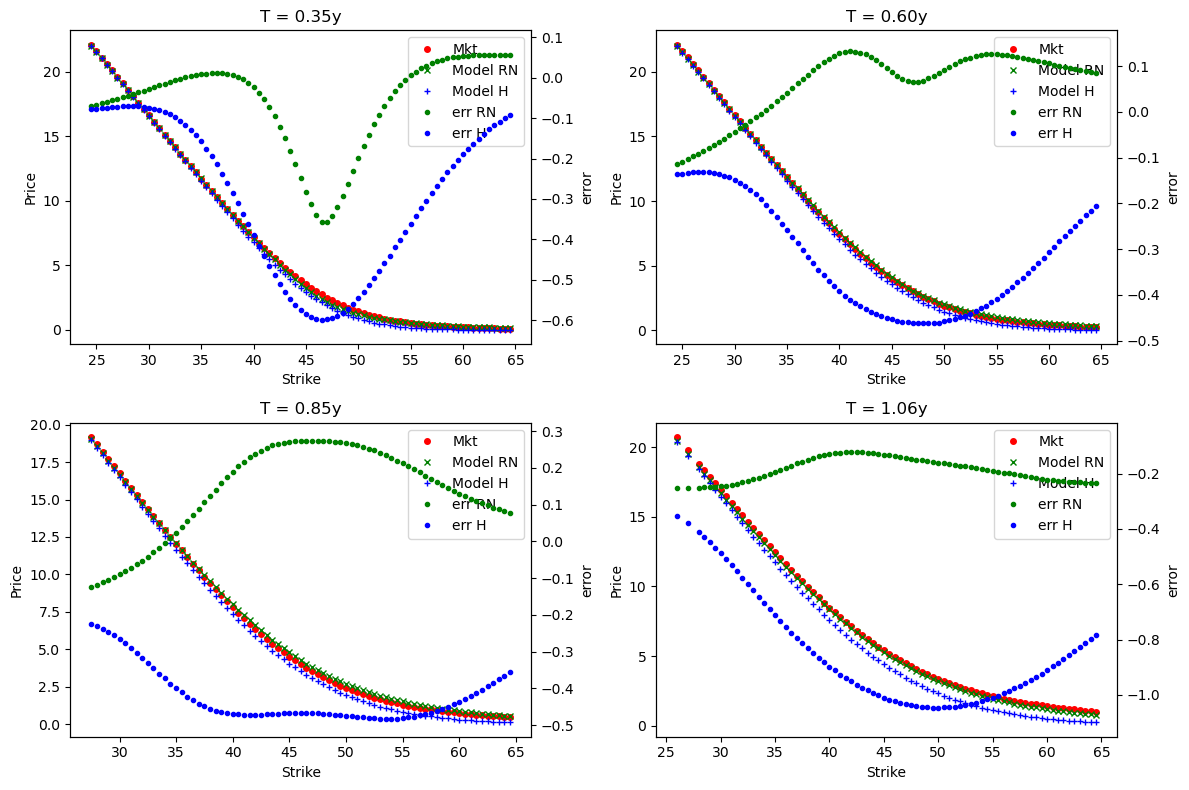

In [13]:
df = snap.copy().sort_values(["T","K"]).reset_index(drop=True)
df["Model_RN"] = np.nan
df["Model_H"]  = np.nan

pars_H  = (theta_hat, nu_hat, sigma_hat)
pars_RN = (theta_rn,  nu_rn,  sigma_rn)

for Tval in np.sort(df["T"].unique()):
    sel = df["T"] == Tval
    Ks  = df.loc[sel, "K"].values
    df.loc[sel, "Model_RN"] = price_slice_fft_b76(F0, r, Tval, *pars_RN,  Ks)
    df.loc[sel, "Model_H"]  = price_slice_fft_b76(F0, r, Tval, *pars_H, Ks)

df["err_RN"] = df["Model_RN"] - df["P"]
df["err_H"]  = df["Model_H"]  - df["P"]

Ts = np.sort(df["T"].unique())
m  = len(Ts)
ncols = 2 if m>=2 else 1
nrows = int(np.ceil(m/ncols))
side  = int(np.ceil(np.sqrt(m)))
if side*side == m:
    nrows = ncols = side

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows), squeeze=False)

for ax, Tval in zip(axes.flat, Ts):
    sl = df[df["T"]==Tval].sort_values("K")

    h_mkt,   = ax.plot(sl["K"], sl["P"],        "ro",  ms=4, label="Mkt")
    h_rn,    = ax.plot(sl["K"], sl["Model_RN"], "gx",  ms=5, label="Model RN")
    h_hist,  = ax.plot(sl["K"], sl["Model_H"],  "b+",  ms=5, label="Model H")
    ax.set_xlabel("Strike")
    ax.set_ylabel("Price")
    ax.set_title(f"T = {Tval:.2f}y")

    ax2 = ax.twinx()
    e_rn,   = ax2.plot(sl["K"], sl["err_RN"], "g.",  ms=6, label="err RN")
    e_hist, = ax2.plot(sl["K"], sl["err_H"],  "b.",  ms=6, label="err H")
    ax2.set_ylabel("error")

    e_all = np.r_[sl["err_RN"].values, sl["err_H"].values]
    pad = 0.1 * (np.max(np.abs(e_all)) if np.any(np.isfinite(e_all)) else 1.0)
    ax2.set_ylim(e_all.min()-pad, e_all.max()+pad)

    handles = [h_mkt, h_rn, h_hist, e_rn, e_hist]
    labels  = ["Mkt", "Model RN", "Model H", "err RN", "err H"]
    ax.legend(handles, labels, loc="best")

for j in range(len(Ts), nrows*ncols):
    fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()

## Discussion of the results
Our fitted RN parameters are again close to Gardini’s ($\theta,\sigma,\nu$)  
$$
\text{Gardini's results: } (0.0900,\,0.2220,\,0.2231),\\
$$
$$
\text{My results: } (0.08115,\,0.22348,\,0.24318).
$$

**On the plots:**  
While Gardini’s figures showed a clear separation between `Model H` and `Model RN` price curves, ours are much closer, especially 'deep in-the-money'. As I did not find any errors in my imlementation, this could be due to possible differences in the exact option dataset used.

The error plots have a similar shape to Gardini’s but are much smaller in magnitude. This raises the possibility that the data I used is more consistent with the model.

## Appendix

### Functions

These functions were implemented based on the Matlab code provided as a supplement to Gardini’s presentation.

- `VGdensity(x, theta, nu, sigma, T)` computes the VG pdf $f_\Theta(x)$ using the Bessel function form for increments of length $T$.  

- `neg_loglike(params, sample, dt)` returns the negative log-likelihood $$-\sum \log f_\Theta(x_i)$$ for given returns and parameters, used for MLE.  

- `VG_simulation(Nsim, nDates, dt, params)` simulates VG log-paths using Gamma-distributed time steps $g$ and Gaussian shocks: $$\Delta X = \theta g + \sigma \sqrt{g} Z$$.  

- `omega_vg(theta, nu, sigma)` computes the martingale correction
$$\omega = \frac{1}{\nu}\log\!\left(1 - \theta\nu - \frac12\sigma^2\nu\right),$$
ensuring $e^{-rT}F_t$ is a martingale under $\mathbb{Q}$.

- `phi_vg_b76(u, F0, omega, T, theta, nu, sigma)` returns the Black-76 VG characteristic function for log-forward prices.  

- `FFTPricing(T, r, phi)` implements Carr–Madan FFT to compute discounted European call prices over a grid of log-strikes from a characteristic function `phi`.  

- `price_slice_fft_b76(F0, r, T, theta, nu, sigma, Ks_query)`: prices calls at specific strikes $K$ for given parameters by FFT + interpolation.  
 
- `resid_vector_squared(x, F0, T, r, K, P)` Computes squared pricing errors $(C_{\text{model}} - P)^2$ for use in least-squares calibration.